In [30]:
using LinearAlgebra;
mutable struct KNNModel
    neighbor::Int32
    metric::String
    trainX::Union{Array, Nothing}
    trainY::Union{Array, Nothing}
end

KNNModel() = KNNModel(3, "euclidean", nothing, nothing);
KNNModel(neighbor_count) = KNNModel(neighbor_count, "euclidean", nothing, nothing);

function fit!(model::KNNModel, X::Array, Y::Array)
    model.trainX = X;
    model.trainY = Y;
end


function predict(model::KNNModel, X::Array)
    Y = zeros(Float32, size(X)[1]);
    for i = 1:size(X)[1]
        cur_neighbors_index = k_neighbors(X[i,:], model.trainX, model.neighbor, model.metric);
        cur_neighbors_y = model.trainY[cur_neighbors_index];
        unique_neighbors = unique(cur_neighbors_y);
        counts = [count(i->(i==x), cur_neighbors_y) for x in unique_neighbors];
        sorted_counts = sort(1:size(unique_neighbors)[1], by=x->counts[x], rev=true);
        Y[i] = unique_neighbors[sorted_counts[1]];
    end
    return Y;
end
    
function distance(m::Array, n::Array, p::Int64)
    return sum((m - n).^p);
end

function k_neighbors(x::Array, X::Array, k::Int32, metric::String)
    if k < 0
        error("negative k is not allowed");
    end
    
    
    distance_list::Array{Float32, 1} = zeros(Float32, size(X)[1]);
    for i = 1:size(X)[1]
        distance_list[i] = distance(x, X[i,:], 2);
    end
    
    index_list = 1:size(X)[1];
    index_list = sort(index_list, by = x->distance_list[x]);
    
    return index_list[1:k];
end


k_neighbors (generic function with 1 method)

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\wangjun\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


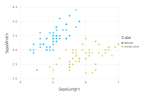

In [3]:
using RDatasets
using Gadfly
iris = dataset("datasets", "iris");
setosaCount = count(i == "setosa" for i in iris.Species);
versicolorCount = count(i == "versicolor" for i in iris.Species);
virginicaCount = count(i == "virginica" for i in iris.Species);

plot(x=iris.SepalLength[1:100], y=iris.SepalWidth[1:100], color=iris.Species[1:100], Geom.point,
    Guide.xlabel("SepalLength"), Guide.ylabel("SepalWidth"))

In [33]:
iris_x = [iris.SepalLength[1:100] iris.SepalWidth[1:100]];
iris_y = recode(iris.Species[1:100], "setosa" => -1, "versicolor" => 1, "virginica" => 0);
iris_y = [convert(Int32,i) for i in iris_y];

model = KNNModel(5);
fit!(model, iris_x, iris_y);
predict(model, [6 2.5;5 4])

3-element Array{Float32,1}:
  1.0
 -1.0
 -1.0

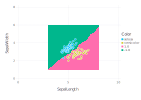

In [60]:
using RDatasets
using Gadfly
iris = dataset("datasets", "iris");
setosaCount = count(i == "setosa" for i in iris.Species);
versicolorCount = count(i == "versicolor" for i in iris.Species);
virginicaCount = count(i == "virginica" for i in iris.Species);

points = layer(x=iris.SepalLength[1:100], y=iris.SepalWidth[1:100], color=iris.Species[1:100], Geom.point)
x_data = collect(Iterators.flatten([len for len=3:0.1:8, width=1:0.1:6]));
y_data = collect(Iterators.flatten([width for len=3:0.1:8, width=1:0.1:6]));
colors = collect(Iterators.flatten([predict(model,[len width])[1] for len=3:0.1:8, width=1:0.1:6]));
lines = layer(x=x_data, y =y_data, color =colors, Geom.rectbin)
plot(points, lines, Guide.xlabel("SepalLength"), Guide.ylabel("SepalWidth"))
